# This notebook shows that limb darkening should be a secondary effect in our sample

Note that this could be different if the flaring area was huge (filling fraction above 0.1)

In [1]:
# basics
import numpy as np
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

In [4]:
# array of distances to the limb
x = np.linspace(0,np.pi/2,40)

# some slow-ish flare decay  (1 e-folding per rotation)
y = 1. * np.exp(-.25 * x)


def limb(x, u):
    return 1 - (1 - np.cos(x)) * u 


# s is the projected size of the flaring region 
s = .2
maxf = 1 / (1 - s)
df = maxf - 1
maxf, df

(1.25, 0.25)

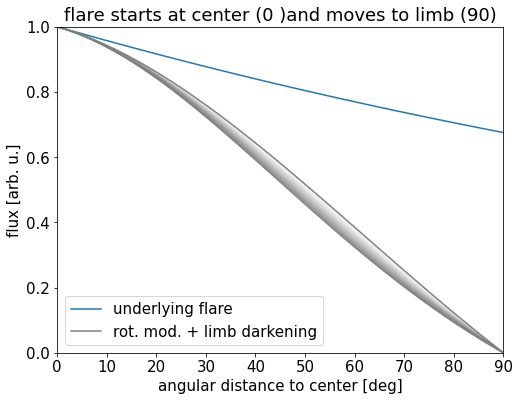

In [5]:
deg = x / np.pi * 180.

plt.figure(figsize=(8,6))

plt.plot(deg,y,label="unmodulated flare")

plt.plot(deg, np.cos(x) * y, c="grey",label="rot. mod. + limb darkening")

# cycle through linear limb darkening coefficients
for u in np.linspace(0.1,1.5,10):
    plt.plot(deg, np.cos(x) * y / (maxf - df * limb(x,u)), c="grey", alpha=u/1.5)

# layout    
plt.ylim(0,1)
plt.xlim(0,90)
plt.xlabel("angular distance to center [deg]")
plt.ylabel("flux [arb. u.]")
plt.title("flare starts at center (0 )and moves to limb (90)")
plt.legend();

In [14]:
1 /(1 / 5.691 / 3600 - 1 / 1909.5)

-2105.7628175109403

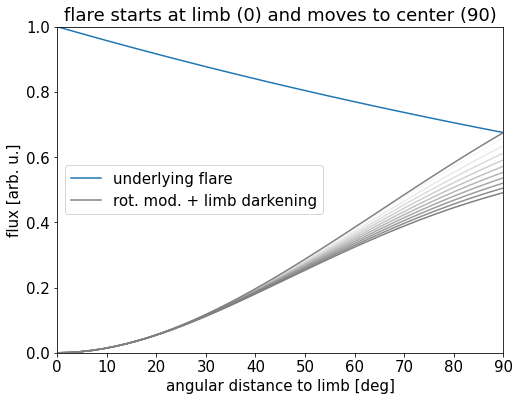

In [6]:
deg = x / np.pi * 180.
plt.figure(figsize=(8,6))
plt.plot(deg,y,label="underlying flare")
plt.plot(deg,(1 - np.cos(x)) * y, label="rot. mod. + limb darkening",c="grey")
for u in np.linspace(0.1,1.5,10):
    plt.plot(deg,(1 - np.cos(x)) * y / (maxf - df * limb(x,u)), c="grey", alpha=u / 1.5)
    
# layout
plt.ylim(0,1)
plt.xlim(0,90)
plt.xlabel("angular distance to limb [deg]")
plt.ylabel("flux [arb. u.]")
plt.title("flare starts at limb (0) and moves to center (90)")
plt.legend();